In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import pyDOE
from multiprocessing import Process
from scipy.stats import norm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params, update_sev_prevalence
from analysis_helpers import poisson_waiting_function

from multi_group_simulation import MultiGroupSimulation

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [3]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [4]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

In [6]:
param_uncertainty = {
    'asymp_prob_mult': (24/47, 70/47), # Our nominal estimate for US population: 47%
    'inital_prev_mult': (0.5, 1.5),
    'R0': (1,4),
    'outside_inf_mult': (0.5, 1.5),
    'daily_self_report_prob': (0.22, 0.5),
    'ct_mult': (1,2),
    'ct_testing_ratio': (0.5, 1.5),
    'test_sensitivity': (0.4, 0.8),
    'test_noncompliance': (0.05, 0.15),
    'E_time': (1,3),
    'ID_time': (2,4),
    'Sy_time': (11,13),
    'virtual_noncompliance': (0.25, 0.75),
    'intermittent_non-compliance': (0.25,0.75),
    'virtual_r0_mult': (0.97, 1.5),
    'virtual_pop_size': (0,1), # Slider from min to max
}

uncertainty_params_list = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance', 'virtual_r0_mult',
                           'virtual_pop_size']

nominal_param_dict = {
    'asymp_prob_mult': 1, # Our nominal estimate for US population: 47%
    'inital_prev_mult': 1,
    'R0': 2.5,
    'outside_inf_mult': 1,
    'daily_self_report_prob': 0.22,
    'ct_mult': 1,
    'ct_testing_ratio': 0.5,
    'test_sensitivity': 0.6,
    'test_noncompliance': 0.1,
    'E_time': 2,
    'ID_time': 3,
    'Sy_time': 12,
    'virtual_noncompliance': 0.5,
    'intermittent_non-compliance': 0.5,
    'virtual_r0_mult': 0.97,
    'virtual_pop_size': 0.71, # Slider from min to max
}

lb = list()
ub = list()

for param in uncertainty_params_list:
    lb.append(param_uncertainty[param][0])
    ub.append(param_uncertainty[param][1])

# Plotting Pessimistic Scenario params

In [7]:
def get_stats(inf_matrix):
    cornell_inf = np.array(inf_matrix)[:,:-1].sum(axis=1)
    ithaca_inf = np.array(inf_matrix)[:,-1]
    return np.quantile(cornell_inf, [0.1,0.5,0.9]), np.quantile(ithaca_inf, [0.1,0.5,0.9])

In [8]:
scenario_data = pd.DataFrame(columns=uncertainty_params_list+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for i in range(200):
    file = open('apr_21_scenarios/point_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    for index, col_name in enumerate(uncertainty_params_list):
        new_row[col_name] = uncertainty_point[index]

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    scenario_data = scenario_data.append(new_row, ignore_index=True)

In [9]:
import statsmodels.api as sm
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = scenario_data[residential_columns]
Y_res_outcomes = np.array(scenario_data[[residential_target]])

X = sm.add_constant(X_res)
model = sm.OLS(Y_res_outcomes,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     16.30
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           2.21e-23
Time:                        17:04:36   Log-Likelihood:                -1631.0
No. Observations:                 200   AIC:                             3288.
Df Residuals:                     187   BIC:                             3331.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    995.8849   1513.837      0.658      0.511   -1990.509    3982.278
asymp_prob_mult          941.9148    229.475      4.105      0.000     489.222    1394.607
inital_prev_mult        -190.9972    229.833     -0.831      0.407    -644.397     262.402
R0                       666.9477     76.599      8.707      0.000     515.839     818.057
outside_inf_mult         174.1239    224.662      0.775      0.439    -269.074     617.322
daily_self_report_prob  -680.6892    771.987     -0.882      0.379   -2203.612     842.234
ct_mult                -1163.4178    235.061     -4.949      0.000   -1627.130    -699.705
ct_testing_ratio        -924.5224    223.899     -4.129      0.000   -1366.215    -482.830
test_sensitivity       -2727.6250    549.398     -4.965      0.000   -3811.439   -1643.811
test_noncompliance      2361.9812   2214.006      1.067      0.287   -2005.657    6729.619
E_time                    31.2164    110.004      0.284      0.777    -185.792     248.225
ID_time                 -161.4988    109.711     -1.472      0.143    -377.929      54.932
Sy_time                  152.5914    109.064      1.399      0.163     -62.563     367.746
==============================================================================
Omnibus:                      121.377   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.245
Skew:                           2.359   Prob(JB):                    8.11e-161
Kurtosis:                      11.137   Cond. No.                         471.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

In [35]:
# lr_summary_df[['coef', 'std err', 't', 'P>|t|']]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = param_uncertainty[param][1] - param_uncertainty[param][0]
    coef_normalized.append(value / param_range)

# lr_summary_df['coef/range']
# dict(lr_summary_df['coef']).items()

In [36]:
coef_normalized

[995.8849,
 962.3912086956523,
 -190.9972,
 222.31590000000003,
 174.1239,
 -2431.032857142857,
 -1163.4178,
 -924.5224,
 -6819.0625,
 23619.812000000005,
 15.6082,
 -80.7494,
 76.2957]

In [37]:
lr_summary_df['coef/range'] = coef_normalized

In [40]:
lr_summary_df.round(1)

,coef,std err,t,P>|t|,[0.025,0.975],coef/range
const,995.9,1513.8,0.7,0.5,-1990.5,3982.3,995.9
asymp_prob_mult,941.9,229.5,4.1,0.0,489.2,1394.6,962.4
inital_prev_mult,-191.0,229.8,-0.8,0.4,-644.4,262.4,-191.0
R0,666.9,76.6,8.7,0.0,515.8,818.1,222.3
outside_inf_mult,174.1,224.7,0.8,0.4,-269.1,617.3,174.1
daily_self_report_prob,-680.7,772.0,-0.9,0.4,-2203.6,842.2,-2431.0
ct_mult,-1163.4,235.1,-4.9,0.0,-1627.1,-699.7,-1163.4
ct_testing_ratio,-924.5,223.9,-4.1,0.0,-1366.2,-482.8,-924.5
test_sensitivity,-2727.6,549.4,-5.0,0.0,-3811.4,-1643.8,-6819.1
test_noncompliance,2362.0,2214.0,1.1,0.3,-2005.7,6729.6,23619.8


In [44]:
lr_results = {'Intercept': 995.88,
'asymp_prob_mult': 941.91,
'inital_prev_mult': -191.00,
'R0': 666.95,
'outside_inf_mult': 174.12,
'daily_self_report_prob': -680.69,
'ct_mult': -1163.42,
'ct_testing_ratio': -924.52,
'test_sensitivity': -2727.62,
'test_noncompliance': 2361.98,
'E_time': 31.22,
'ID_time': -161.50,
'Sy_time': 152.59}

In [45]:
range_dict = dict()
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']
for param in res_params:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in res_params:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in res_params:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 1.1537243162698188,
 'inital_prev_mult': 0.9674578245577438,
 'R0': 3.5227017549786117,
 'outside_inf_mult': 1.0296661967958411,
 'daily_self_report_prob': 0.3509075975984278,
 'ct_mult': 1.3017789646438236,
 'ct_testing_ratio': 0.8424822406289283,
 'test_sensitivity': 0.5256438210849786,
 'test_noncompliance': 0.10402429149482201,
 'E_time': 2.021276789891251,
 'ID_time': 2.8899358882947777,
 'Sy_time': 12.103991843994427}

In [46]:
centre_point = dict()
direction = dict()
for param in res_params:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [43]:
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']

def normalize_param(param_name, value):
    lower_bound = param_uncertainty[param_name][0]
    upper_bound = param_uncertainty[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

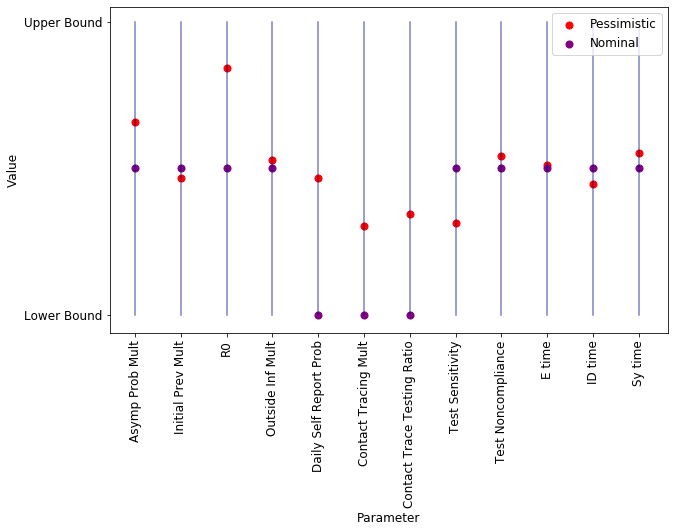

In [67]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(res_params):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, pess_scenario[param]), color='red', label='Pessimistic', s=50)
        plt.scatter(index, normalize_param(param, nominal_param_dict[param]), color='purple', label='Nominal', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, pess_scenario[param]), color='red', s=50)
        plt.scatter(index, normalize_param(param, nominal_param_dict[param]), color='purple', s=50)

plt.xticks(list(range(len(res_params))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'E time', 'ID time', 'Sy time'])
plt.xticks(rotation = 90)
plt.yticks([0,1], ['Lower Bound', 'Upper Bound'])

plt.xlabel('Parameter')
plt.ylabel('Value')

plt.legend(loc='upper right')
plt.show()